### Instructor Demo: Stock Portfolio Forecasting

This program executes `1000` simulations of stock price trajectory for `JNJ` and `MU` over the next `252` trading days (or year of trading), based on a normal probability distribution of potential daily returns derived from the corresponding sample means and standard deviations. Daily and cumulative portfolio returns are then calculated, using `60%` of capital allocated to `JNJ` and `40%` of capital allocated to `MU`, to analyze the probability distribution and confidence interval of potential ending cumulative portfolio returns.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': '02b6820c-e5d5-462f-b3d0-d600919dffd7',
     'marginable': True,
     'name': 'Direxion Daily Gold Miners Bull 3X Shares of Direxion Shares ETF '
             'Trust',
     'shortable': False,
     'status': 'active',
     'symbol': 'NUGT',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'd174dc71-0a75-47a7-a43c-5cf9360111bf',
     'marginable': True,
     'name': 'ETF Series Solutions Trust Loncar Cancer Immunotherapy ETF',
     'shortable': False,
     'status': 'active',
     'symbol': 'CNCR',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': '07844fc5-d49c-41dd-a543-dccaf6aec65c',
     'marginable': True,
     'name': 'Co-Diagnostics, Inc. Common Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'CODX',
     't

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,NUGT
1,CNCR
2,CODX
3,TDOC
4,ONEM
5,CRAI
6,SPWH
7,MEXX_deprecated
8,SDPI
9,KREF


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the list of tickers
tickers = ["JNJ", "MU"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

JNJ                                      MU  \
                             open    high     low   close   volume   open   
2019-11-04 00:00:00-05:00  131.80  131.95  130.09  130.25  4783710  49.39   
2019-11-05 00:00:00-05:00  130.53  131.47  129.68  130.42  4650959  49.62   
2019-11-06 00:00:00-05:00  130.42  131.48  129.70  130.96  3349382  48.15   
2019-11-07 00:00:00-05:00  131.73  132.38  131.01  131.56  4757646  48.52   
2019-11-08 00:00:00-05:00  131.30  133.04  130.97  132.97  4047354  47.56   

                                                            
                             high     low  close    volume  
2019-11-04 00:00:00-05:00  49.900  49.250  49.60  14911674  
2019-11-05 00:00:00-05:00  49.720  48.605  48.68  13015997  
2019-11-06 00:00:00-05:00  48.300  47.105  47.68  20119517  
2019-11-07 00:00:00-05:00  49.080  48.000  48.43  18385442  
2019-11-08 00:00:00-05:00  48.005  46.950  47.18  17334308

### Drop Extraneous Columns

In [6]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,JNJ,MU
,close,close
2019-11-04 00:00:00-05:00,130.25,49.60
2019-11-05 00:00:00-05:00,130.42,48.68
2019-11-06 00:00:00-05:00,130.96,47.68
2019-11-07 00:00:00-05:00,131.56,48.43
2019-11-08 00:00:00-05:00,132.97,47.18


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of `JNJ` and `MU`.
daily_returns = df.pct_change()
daily_returns.head()

,JNJ,MU
,close,close
2019-11-04 00:00:00-05:00,NaN,NaN
2019-11-05 00:00:00-05:00,0.001305,-0.018548
2019-11-06 00:00:00-05:00,0.004140,-0.020542
2019-11-07 00:00:00-05:00,0.004582,0.015730
2019-11-08 00:00:00-05:00,0.010718,-0.025810


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for `JNJ` and `MU`, respectively
avg_daily_return_jnj = daily_returns.mean()['JNJ']['close']
avg_daily_return_mu = daily_returns.mean()['MU']['close']
avg_daily_return_mu

-0.00035364215612684066

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for `JNJ` and `MU`, respectively
std_dev_daily_return_jnj = daily_returns.std()['JNJ']['close']
std_dev_daily_return_mu = daily_returns.std()['MU']['close']
std_dev_daily_return_mu

0.04351582478774182

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 252

# Set last closing prices of `JNJ` and `MU`
jnj_last_price = df['JNJ']['close'][-1]
mu_last_price = df['MU']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    simulated_jnj_prices = [jnj_last_price]
    simulated_mu_prices = [mu_last_price]
    
    # Simulate the returns for 252 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_jnj_price = simulated_jnj_prices[-1] * (1 + np.random.normal(avg_daily_return_jnj, std_dev_daily_return_jnj))
        simulated_mu_price = simulated_mu_prices[-1] * (1 + np.random.normal(avg_daily_return_mu, std_dev_daily_return_mu))
        
        # Append the simulated price to the list
        simulated_jnj_prices.append(simulated_jnj_price)
        simulated_mu_prices.append(simulated_mu_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["JNJ prices"] = pd.Series(simulated_jnj_prices)
    simulated_price_df["MU prices"] = pd.Series(simulated_mu_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% JNJ; 40% MU)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.016201,1.006723,0.940274,0.968550,1.015832,0.972083,1.015698,0.979870,1.024727,1.016629,...,0.990775,1.015953,0.985120,1.044184,0.974126,0.951367,1.025041,1.017288,0.999415,0.990828
2,0.991596,1.011381,0.923898,0.940726,1.039979,0.957146,1.021319,0.946335,1.009916,1.016185,...,1.036338,1.005707,0.966388,1.041641,0.981900,0.945773,1.030110,1.027771,1.033631,0.989069
3,0.978636,1.017932,0.991173,0.944160,1.085574,0.933839,1.071349,0.907337,1.043072,0.996839,...,1.058181,0.990358,0.958983,1.029085,0.931307,1.006710,1.061407,1.050690,1.054156,0.981079
4,0.979351,0.985038,0.996920,0.941199,1.152460,0.935355,1.098144,0.909305,1.091993,1.034871,...,1.048603,1.033521,0.964702,0.988319,0.919846,1.029241,1.095707,1.076896,1.070995,0.974333


### Plot the Multiple Simulations of Potential Cumulative Portfolio Returns over the Next Year (252 Trading Days)

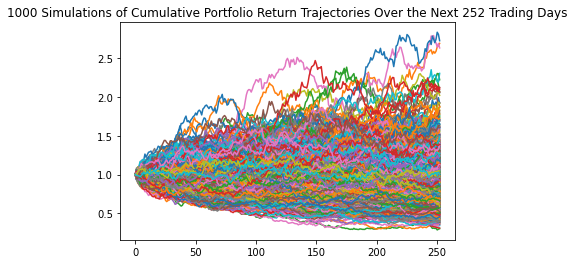

In [11]:
# Use the `plot` function to plot `1000` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for project stock prices (prices of each simulation on the 252nd trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    1.088686
1    0.726078
2    0.841872
3    1.109965
4    0.687122
Name: 252, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Portfolio Cumulative Returns on the 252nd Trading Day

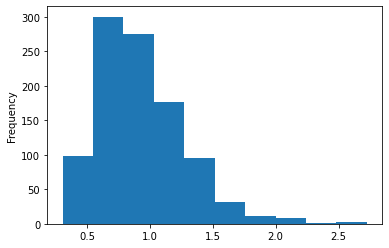

In [13]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)

### Calculate the Probability Distribution of Ending Cumulative Return Ranges

In [14]:
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(0.545, 0.788]    0.300
(0.788, 1.03]     0.275
(1.03, 1.272]     0.177
(0.3, 0.545]      0.098
(1.272, 1.515]    0.095
(1.515, 1.757]    0.031
(1.757, 1.999]    0.012
(1.999, 2.241]    0.008
(2.484, 2.726]    0.003
(2.241, 2.484]    0.001
Name: 252, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Cumulative Portfolio Returns

In [15]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.433210
0.975    1.740494
Name: 252, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Cumulative Portfolio Returns 

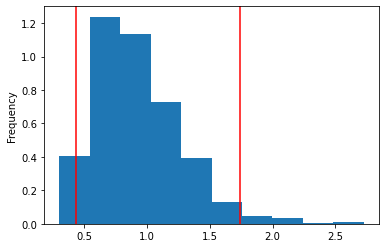

In [16]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in the Portfolio over the Next 252 Trading Days

In [17]:
# Set initial investment
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval.iloc[0])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval.iloc[1])
                                                    
# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 252 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 252 trading days will end within in the range of $14332.095451098725 and $27404.93932677215
